<a href="https://colab.research.google.com/github/learning-mach/machine/blob/test/WebPageIdentify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U --pre tensorflow=="2.4.1"

Requirement already up-to-date: tensorflow==2.4.1 in /usr/local/lib/python3.7/dist-packages (2.4.1)


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2648, done.
remote: Counting objects: 100% (2648/2648), done.
remote: Compressing objects: 100% (2189/2189), done.
remote: Total 2648 (delta 672), reused 1293 (delta 426), pack-reused 0
Receiving objects: 100% (2648/2648), 32.61 MiB | 29.90 MiB/s, done.
Resolving deltas: 100% (672/672), done.


In [3]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

Selecting previously unselected package python-bs4.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [4]:
!pip install -qq Cython contextlib2 pillow lxml matplotlib pycocotools

In [ ]:
#%cd /content/


/content


# New Section

In [6]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1648944 sha256=174179dc9774c267998755e51de84427f5bd072766ef1dbf130aba5d34cc545e
  Stored in directory: /tmp/pip-ephem-wheel-cache-7hwgtp1m/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [7]:


import os
os.environ['PYTHONPATH'] += ':/models/research/:/models/research/slim/'

%cd models/research/

!python object_detection/builders/model_builder_tf2_test.py


#python object_detection/builders/model_builder_tf2_test.py




/content/models/research
2021-05-17 04:13:10.598682: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-05-17 04:13:13.937837: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-17 04:13:13.982706: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-17 04:13:14.064827: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-17 04:13:14.064915: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ae21b45ecec9): /proc/driver/nvidia/version does not exist
2021-05-17 04:13:14.065476: I tensorflow/compiler/jit/xla_gpu_device.cc

In [8]:
from google.colab import drive
 
drive.mount('/gdrive')# the project's folder
%cd /gdrive/'My Drive'/WebData

Mounted at /gdrive
/gdrive/My Drive/WebData


In [9]:
import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict

from google.colab import files


import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import tensorflow.compat.v1 as tf



Run below cell only if you want to do partition

In [ ]:
%cd /gdrive/'My Drive'/WebData
#creating two dir for training and testing
!mkdir test_labels train_labels

# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 10 labels (% of the labels) to the testing dir: `test_labels`
!ls Annotation/* | sort -R | head -8 | xargs -I{} mv {} test_labels/


# Moves the rest of labels '1600' labels to the training dir: `train_labels`
!ls Annotation/* | xargs -I{} mv {} train_labels/

/gdrive/My Drive/WebData


In [ ]:
######not run

def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names


#for label_path in ['train_labels', 'test_labels']: #test label myt not have all labels, thus already the ordered for pbtxt
for label_path in ['test_labels', 'train_labels',]:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)




Successfully converted test_labels xml to csv.
Successfully converted train_labels xml to csv.


In [35]:
data_base_url = '/gdrive/My Drive/WebData/'
column_name_class = ["class_new"]

df = pd.read_csv(data_base_url+"train_labels.csv")

print(df)


                                                filename  width  ...  xmax ymax
0      smile_amazon_com_png.rf.009f16f3fbce213af11c49...   1024  ...   593   50
1      smile_amazon_com_png.rf.009f16f3fbce213af11c49...   1024  ...   420  121
2      smile_amazon_com_png.rf.009f16f3fbce213af11c49...   1024  ...   617  121
3      smile_amazon_com_png.rf.009f16f3fbce213af11c49...   1024  ...   722  172
4      smile_amazon_com_png.rf.009f16f3fbce213af11c49...   1024  ...   723  229
...                                                  ...    ...  ...   ...  ...
38405  teespring_com_png.rf.ffce10646dde0523b2566a0b2...   1024  ...   446  505
38406  teespring_com_png.rf.ffce10646dde0523b2566a0b2...   1024  ...   223  561
38407  teespring_com_png.rf.ffce10646dde0523b2566a0b2...   1024  ...   350  768
38408  teespring_com_png.rf.ffce10646dde0523b2566a0b2...   1024  ...   657  768
38409  teespring_com_png.rf.ffce10646dde0523b2566a0b2...   1024  ...   964  768

[38410 rows x 8 columns]


In [36]:
df2_tidy = df.rename(columns = {'class': 'newclass'}, inplace = False)



print(df2_tidy)

                                                filename  width  ...  xmax ymax
0      smile_amazon_com_png.rf.009f16f3fbce213af11c49...   1024  ...   593   50
1      smile_amazon_com_png.rf.009f16f3fbce213af11c49...   1024  ...   420  121
2      smile_amazon_com_png.rf.009f16f3fbce213af11c49...   1024  ...   617  121
3      smile_amazon_com_png.rf.009f16f3fbce213af11c49...   1024  ...   722  172
4      smile_amazon_com_png.rf.009f16f3fbce213af11c49...   1024  ...   723  229
...                                                  ...    ...  ...   ...  ...
38405  teespring_com_png.rf.ffce10646dde0523b2566a0b2...   1024  ...   446  505
38406  teespring_com_png.rf.ffce10646dde0523b2566a0b2...   1024  ...   223  561
38407  teespring_com_png.rf.ffce10646dde0523b2566a0b2...   1024  ...   350  768
38408  teespring_com_png.rf.ffce10646dde0523b2566a0b2...   1024  ...   657  768
38409  teespring_com_png.rf.ffce10646dde0523b2566a0b2...   1024  ...   964  768

[38410 rows x 8 columns]


In [39]:
classes_names = []
letters = df2_tidy.newclass.tolist()
print(letters)
classes_names = list(set(letters))
classes_names.sort()

['image', 'heading', 'heading', 'text', 'text', 'text', 'label', 'field', 'field', 'text', 'link', 'text', 'link', 'text', 'image', 'button', 'text', 'heading', 'button', 'image', 'link', 'link', 'link', 'link', 'link', 'text', 'image', 'heading', 'link', 'link', 'link', 'field', 'link', 'link', 'link', 'link', 'link', 'link', 'link', 'link', 'link', 'link', 'link', 'link', 'link', 'link', 'image', 'text', 'text', 'text', 'text', 'text', 'button', 'text', 'button', 'image', 'link', 'link', 'link', 'link', 'text', 'link', 'text', 'text', 'button', 'image', 'link', 'link', 'link', 'link', 'text', 'link', 'text', 'text', 'button', 'image', 'link', 'link', 'link', 'link', 'text', 'link', 'text', 'text', 'button', 'image', 'link', 'link', 'link', 'link', 'text', 'link', 'text', 'text', 'button', 'image', 'link', 'link', 'link', 'link', 'text', 'link', 'text', 'text', 'button', 'image', 'link', 'link', 'link', 'link', 'text', 'link', 'text', 'heading', 'heading', 'button', 'link', 'text', 'i

In [40]:
label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes_names):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)


In [41]:
#####old
from object_detection.utils import dataset_util, label_map_util

%cd /gdrive/'My Drive'/WebData
label_map = label_map_util.load_labelmap(label_map_path)
label_map_dict = label_map_util.get_label_map_dict(label_map)

/gdrive/My Drive/WebData


In [42]:
print(label_map_dict)

{'button': 1, 'field': 2, 'heading': 3, 'iframe': 4, 'image': 5, 'label': 6, 'link': 7, 'text': 8}


In [43]:


#change this to the base directory where your data/ is 
data_base_url = '/gdrive/My Drive/WebData/'

#location of images
image_dir = data_base_url +'WebPages/'

def class_text_to_int(row_label):
    return label_map_dict[row_label]


def split(df, group):
  data = namedtuple('data', ['filename', 'object'])
  gb = df.groupby(group)
  return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example




def CreateMainTFrecord():
  for csv in ['train_labels', 'test_labels']:
      writer = tf.python_io.TFRecordWriter(data_base_url + csv + '.record')
      path = os.path.join(image_dir)
      #examples = xml_to_csv(args.xml_dir)
      examples = pd.read_csv(data_base_url + csv + '.csv')
      grouped = split(examples, 'filename')
      for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())
        
      writer.close()
      output_path = os.path.join(os.getcwd(), data_base_url + csv + '.record')
      print('Successfully created the TFRecords: {}'.format(data_base_url +csv + '.record'))




In [44]:
CreateMainTFrecord()

Successfully created the TFRecords: /gdrive/My Drive/WebData/train_labels.record
Successfully created the TFRecords: /gdrive/My Drive/WebData/test_labels.record


In [10]:
# Some models to train on
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
    },
    'ssd_resnet50_v1': {
        'model_name': 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8',
    },
}

# Select a model from `MODELS_CONFIG`.
# I chose ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'ssd_resnet50_v1'

In [11]:
#the distination folder where the model will be saved
#change this if you have a different working dir

%cd /content/
!mkdir pretrained_model
!mkdir Training
!mkdir output
!mkdir outputGraph
%cd /content/pretrained_model/


/content
/content/pretrained_model


In [12]:
DEST_DIR = '/content/pretrained_model'
DEST_DIR = '/content/pretrained_model'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'

#checks if the model has already been downloaded, download it otherwise
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the model and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()


# creating an output file to save the model while training
os.remove(MODEL_FILE)
#if (os.path.exists(DEST_DIR)):
    #shutil.rmtree(DEST_DIR)
#os.rename(MODEL, DEST_DIR)

In [13]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/pretrained_model
total 12K
drwxr-xr-x 3 root   root  4.0K May 17 04:18 .
drwxr-xr-x 1 root   root  4.0K May 17 04:18 ..
drwxr-x--- 4 345018 89939 4.0K Jul 11  2020 ssd_resnet50_v1_fpn_640x640_coco17_tpu-8


In [ ]:
###TRaining
#!python3 object_detection/model_main.py \
#    --pipeline_config_path=/gdrive/My\ Drive/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
#    --model_dir=training/

Training

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py --model_dir=/gdrive/MyDrive/WebData/Trained --pipeline_config_path=/content/pretrained_model/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0516 19:04:24.951995 140578822158208 mirrored_strategy.py:350] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0516 19:04:24.956229 140578822158208 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0516 19:04:24.956411 140578822158208 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0516 19:04:24.983461 140578822158208 deprecation.py:339] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:551: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from_function
INFO

In [ ]:
#!python /content/models/research/object_detection/model_main_tf2.py --model_dir=/content/Training --pipeline_config_path=/content/pretrained_model/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config

Extract

In [17]:
!python /content/models/research/object_detection/exporter_main_v2.py \
--trained_checkpoint_dir=/gdrive/MyDrive/WebData/Trained \
--pipeline_config_path=/content/pretrained_model/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config \
--output_directory /gdrive/MyDrive/WebData/output

2021-05-17 04:28:16.721696: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0517 04:28:17.731318 140554016868224 deprecation.py:604] From /usr/local/lib/python3.7/dist-packages/object_detection/exporter_lib_v2.py:106: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0517 04:28:43.101324 140554016868224 save_impl.py:78] Skipping full serialization of Keras l

In [34]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/output'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/gdrive/My Drive/WebData/label_map.pbtxt'

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  '/gdrive/My Drive/WebData/validation'

#assert os.path.isfile(PATH_TO_CKPT)
#assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/gdrive/My Drive/WebData/validation/img (1).jpg', '/gdrive/My Drive/WebData/validation/img (3).jpg', '/gdrive/My Drive/WebData/validation/img (2).jpg', '/gdrive/My Drive/WebData/validation/fr-fr_facebook_com_png.rf.69bfc4edc6294eea9d014ac1a6136a2a.jpg', '/gdrive/My Drive/WebData/validation/raw_githubusercontent_com_png.rf.66aff185c151b282c97f88edc14e5bd1.jpg']


LOAD THE SAVED MODEL

In [21]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import tensorflow as tf

#PATH_TO_SAVED_MODEL = PATH_TO_CKPT + "/saved_model/"
PATH_TO_SAVED_MODEL = "/gdrive/MyDrive/WebData/output/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL, tags=None, options=None)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 20.621779441833496 seconds


In [23]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

Running inference for /gdrive/My Drive/WebData/WebPages/500px_com_png.rf.f015eafe7d46f5c079c44eff3790befa.jpg... Done


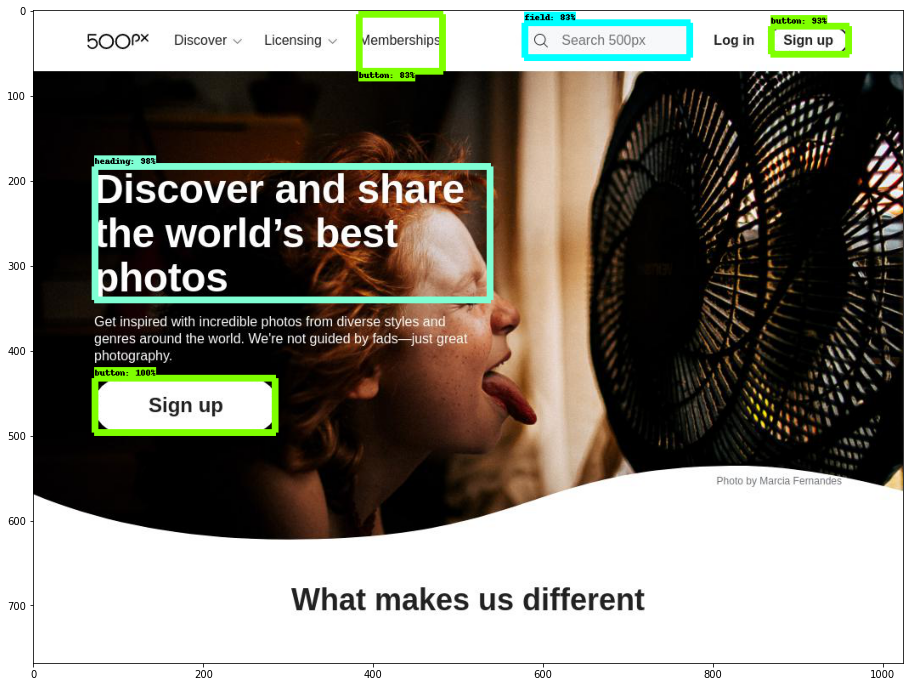

[0.99759936 0.98386455 0.9276325  0.83287    0.8253055  0.67828083
 0.6691938  0.6234239  0.5300373  0.49139738 0.4683619  0.45567107
 0.45097998 0.37513715 0.372765   0.36305922 0.34825605 0.3301369
 0.31099576 0.28939283 0.26334453 0.24800491 0.24698827 0.22981238
 0.22373843 0.21603519 0.21576092 0.20656025 0.20018506 0.19321057
 0.18875387 0.17776003 0.17619315 0.16988993 0.16784713 0.16044945
 0.1553827  0.14900404 0.1460827  0.14250493 0.14215618 0.13504672
 0.13241029 0.1320895  0.1294797  0.12625644 0.12507197 0.12504926
 0.12264764 0.12165728 0.1205366  0.12043431 0.11983246 0.11705181
 0.1149492  0.11378145 0.11247805 0.11049443 0.10931259 0.10874987
 0.10844639 0.10503945 0.10467085 0.10451818 0.10380554 0.10347033
 0.10207346 0.10196447 0.10172597 0.0999456  0.09972784 0.09952655
 0.0977633  0.09514931 0.09400111 0.09386179 0.09120303 0.09044597
 0.08930162 0.08860958 0.08856636 0.08685809 0.08649787 0.08582401
 0.08475333 0.08470404 0.08272871 0.08226421 0.08074445 0.07872

In [38]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
TEST_IMAGE_PATHS = ['/gdrive/My Drive/WebData/WebPages/500px_com_png.rf.f015eafe7d46f5c079c44eff3790befa.jpg']
#TEST_IMAGE_PATHS = ['/gdrive/My Drive/WebData/validation/raw_githubusercontent_com_png.rf.66aff185c151b282c97f88edc14e5bd1.jpg']
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in TEST_IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    #print(detections['detection_classes'])
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8,
          max_boxes_to_draw=200,
          min_score_thresh=.8,
          agnostic_mode=False)

    plt.figure(figsize=(20,12))
    plt.imshow(image_np_with_detections)
    print('Done')

plt.show()
print(detections['detection_scores'])
print(detections['detection_classes'])
print(detections['detection_boxes'])


In [ ]:
from matplotlib import pyplot as plt2
%matplotlib inline
def load_image_into_numpy_array2(image_path):
    image = Image.open(image_path)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
      
image_np2 = load_image_into_numpy_array2('/gdrive/My Drive/WebData/validation/1.JPG')
#print(image_np2)
IMAGE_SIZE = (12, 8)
plt2.figure(figsize=IMAGE_SIZE)
#plt2.figure()
plt2.imshow(image_np2)
plt2.show()

In [ ]:
#http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz